# Airfoil-Turbulence Interaction
## Current status: airfoil is static
### Next task: Convect the airfoil upstream

In [24]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

## NACA airfoil
function to create a NACA four digit airfoil

In [25]:
def naca_airfoil(code, num_points, zero_thick_te=False, uniform=False):
    """Return a NACA 4-digit series airfoil"""
    # extract parameters from 4-digit code
    code_str = "%04d" % int(code)
    if len(code_str) != 4:
        raise ValueError("NACA designation is more than 4 digits")
    max_camber = 0.01 * int(code_str[0])
    p = 0.1 * int(code_str[1])  # location of max camber
    thickness = 0.01 * int(code_str[2:])
    if uniform:
        x = np.linspace(0, 1, num_points)
    else:
        # closer spacing near leading edge
        theta = np.linspace(0, 0.5 * np.pi, num_points)
        x = 1 - np.cos(theta)

    # thickness
    coefs = [-0.1015, 0.2843, -0.3516, -0.1260, 0, 0.2969]
    if zero_thick_te:
        coefs[0] = -0.1036
    y_thick = 5 * thickness * (np.polyval(coefs[:5], x) +
                               coefs[5] * np.sqrt(x))

    # camber
    front = np.where(x <= p)
    back = np.where(x > p)
    y_camber = np.zeros_like(x)
    if p:
        y_camber[front] = max_camber * x[front] / p**2 * (2 * p - x[front])
        y_camber[back] = max_camber * ((1. - x[back])/(1. - p)**2 *
                                       (1 + x[back] - 2 * p))
    x = np.hstack([x[-1:0:-1], x])
    y = np.hstack([y_camber[-1:0:-1] + y_thick[-1:0:-1],
                   y_camber - y_thick])
    return (np.array([x, y]).T)

# define airfoil & observation points on it
The mid point between two coordinates on the airfoil surface will act as the observation point. The induced velocity from a vortex to the observation point on the airfoil surface will only have tangent component (flow-tangency and no flow-penetration at the surface). 

In [26]:
q = naca_airfoil(0012, 1001) #NACA0012 airfoil with 500
q_mid = (q[1:] + q[:-1])/2 #mid-point on the panel

#observation points on the airfoil
obsx = q_mid[:,0]
obsy = q_mid[:,1]
obsX = np.vstack((obsx,obsy))

dq = np.diff(q, axis=0) 
numpanels = dq.shape[0]
lengths = np.linalg.norm(dq, axis=1) 
normals = np.transpose(np.array([dq[:,1], -dq[:,0]]) / lengths)
tangents = -np.transpose(np.array([dq[:,0], dq[:,1]]) / lengths) 

## define parameters

In [27]:
length = 10. #nondimensional length of window
height = 1. #window height
N = 100 #number of vortices
gammas = 1. #vortex strength RMS (normal distribution)
rscale = 0.1 #vortex size scale (rayleigh distribution parameter)
t0 = -1.#start time for observation of convection
t1 = 1.#end time
ts = 0.001 # time step
v0 = 5 #convection speed
t = np.arange(t0,t1,ts)

## set random distribution for vortex location, size and strength
origin at window center

In [28]:
vortx = np.random.uniform(low=-length/2,high=length/2,size=N)
vorty = np.random.uniform(low=-height/2,high=height/2,size=N)
vortX = np.vstack((vortx,vorty))
gamma = np.random.normal(scale=gammas,size=N)
rho = np.random.rayleigh(scale=rscale,size=N)

vortex induced velocity is the minimum of $u_\theta = \frac{\Gamma}{2 \pi r}$ and $u_\theta = \frac{\Gamma r}{2\pi r_0^2}$

In [29]:
dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N
utheta = (0.5/np.pi)*gamma*np.minimum(1/r,r/rho) # dim timesteps x N
# comment out one of the two following lines to get alternative vortex models:
# utheta = (0.5/np.pi)*gamma/r 
# utheta = gamma*rho**(1.5)*np.exp(-9*rho*rho*r*r)
# into cartesian coords
uind = utheta * dist[::-1] # dim 2 x timesteps x N
uind[0] *= -1 # change sign for ux (to get correct rotation)
# sum over vortices
utot = uind.sum(2) # dim 2 x timesteps 
utot_tangent = utot.T * tangents # surface tangent component

## plot time histories and psd for induced velocity

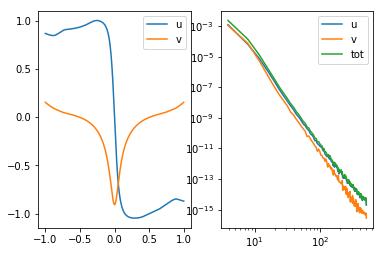

In [30]:
plt.figure(2)
plt.subplot(1,2,1)
plt.plot(t,utot_tangent[:,0],label='u')
plt.plot(t,utot_tangent[:,1],label='v')
plt.legend()
plt.subplot(1,2,2)
(valu,freq) = psd(utot_tangent[:,0],Fs=1/ts,detrend='mean')
(valv,freq) = psd(utot_tangent[:,1],Fs=1/ts,detrend='mean')
plt.loglog(freq[1:],valu[1:],label='u')
plt.loglog(freq[1:],valv[1:],label='v')
plt.loglog(freq[1:],valu[1:]+valv[1:],label='tot')
plt.legend()